#### Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle

from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.neural_network import MLPRegressor

%matplotlib inline

In [2]:
df = pd.read_csv('NFL_2018_PASSING_MASTER.csv')

In [3]:
df.head()

,Rk,Player,Pos,Age,Lg,Tm,Opp,Home_Tm,Result,Points_for,...,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,1,Ryan Fitzpatrick,QB,35.289,NFL,TAM,NOR,NOR,W,48,...,28,75.00,417,4,0,156.2,0,0,14.89,17.75
1,2,Aaron Rodgers,QB,34.281,NFL,GNB,CHI,GNB,W,24,...,30,66.67,286,3,0,130.7,2,19,9.53,11.53
2,3,Drew Brees,QB,39.237,NFL,NOR,TAM,NOR,L,40,...,45,82.22,439,3,0,129.5,1,7,9.76,11.09
3,4,Patrick Mahomes,QB,22.357,NFL,KAN,LAC,LAC,W,38,...,27,55.56,256,4,0,127.5,1,0,9.48,12.44
4,5,Joe Flacco,QB,33.236,NFL,BAL,BUF,BAL,W,47,...,34,73.53,236,3,0,121.7,1,0,6.94,8.71


In [5]:
df.shape

(622, 25)

In [6]:
df = df[df['Pos'] == 'QB']

In [7]:
df.shape

(574, 25)

In [8]:
df = df[df['Att'] > 10]

In [10]:
df.shape

(527, 25)

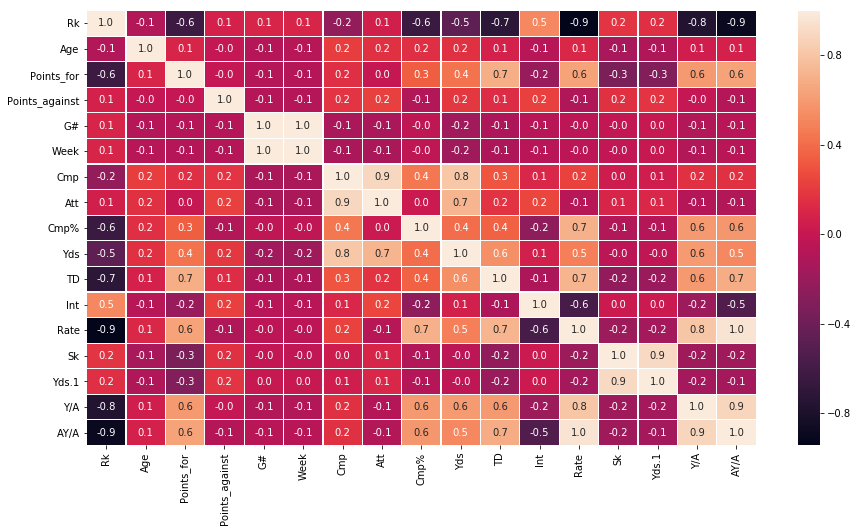

In [12]:
f,ax = plt.subplots(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, linewidths=.2, fmt='.1f', ax=ax)
plt.show()

## Random Forest

In [15]:
features = df[['Age', 'Points_for', 'Points_against', 'Week', 'Att',
               'Cmp%', 'Yds', 'Int', 'Rate', 'Sk', 'Y/A']]

features.head()

,Age,Points_for,Points_against,Week,Att,Cmp%,Yds,Int,Rate,Sk,Y/A
0,35.289,48,40,1,28,75.00,417,0,156.2,0,14.89
1,34.281,24,23,1,30,66.67,286,0,130.7,2,9.53
2,39.237,40,48,1,45,82.22,439,0,129.5,1,9.76
3,22.357,38,28,1,27,55.56,256,0,127.5,1,9.48
4,33.236,47,3,1,34,73.53,236,0,121.7,1,6.94


In [20]:
from sklearn.ensemble import RandomForestRegressor

rfr = ensemble.RandomForestRegressor(n_estimators=500)

X = features[['Age', 'Points_against', 'Week', 'Att',
              'Cmp%', 'Yds', 'Int', 'Sk', 'Y/A']]
Y = df['TD']

from sklearn.model_selection import cross_val_score

score = cross_val_score(rfr, X, Y, cv=5)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.41233412 0.16289655 0.40373686 0.19215635 0.41760459]
Accuracy: 0.32 (+/- 0.23)


In [21]:
# Trying to increase the estimators and changing criterion to 'mae' to see how it impacts the result
rfr = ensemble.RandomForestRegressor(n_estimators=1000, criterion='mae')

X = features[['Age', 'Points_against', 'Week', 'Att',
              'Cmp%', 'Yds', 'Int', 'Sk', 'Y/A']]
Y = df['TD']

score = cross_val_score(rfr, X, Y, cv=5)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

# Minimal impact there, except for the runtime

[0.37497108 0.17641201 0.37872163 0.1959255  0.41815903]
Accuracy: 0.31 (+/- 0.20)


In [23]:
rfr.fit(X, Y)

feature_importances = pd.DataFrame(rfr.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
Y/A,0.298394
Yds,0.209293
Age,0.115776
Points_against,0.091204
Cmp%,0.082256
Week,0.064811
Att,0.063773
Sk,0.050003
Int,0.024490


### Boosting Model

In [26]:
model = ensemble.GradientBoostingRegressor(n_estimators=400, random_state=0,
                                  max_depth=5, learning_rate=0.1, subsample=1)
model.fit(X, Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=0, subsample=1,
             verbose=0, warm_start=False)

In [29]:
model.score(X, Y)

0.9994887884537739

In [30]:
cross_val_score(model, X, Y, cv=5)

array([0.34834758, 0.08136738, 0.37056992, 0.05610655, 0.32991662])

### SKLearn MLPRegressor

In [28]:
mlp = MLPRegressor(hidden_layer_sizes=(1000,))
mlp.fit(X, Y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [31]:
mlp.score(X, Y)

0.4815856397567027

In [32]:
cross_val_score(mlp, X, Y, cv=5)

array([ 0.525208  , -0.29098334,  0.14995476, -4.53577159, -2.72926881])